## DenseNet-121

### Imports and constants

In [2]:
import os

os.chdir(os.pardir)
print(os.getcwd())

/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection


In [3]:
import pandas as pd
import mlflow
import torch
import torch.nn as nn
import torchvision
import preprocessing.data_collector
import preprocessing.data_processor
import train_eval.train
import train_eval.eval

import importlib

importlib.reload(preprocessing.data_collector)
importlib.reload(preprocessing.data_processor)
importlib.reload(train_eval.train)
importlib.reload(train_eval.eval)

<module 'train_eval.eval' from '/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/train_eval/eval.py'>

In [4]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
cpu = torch.device("cpu")

In [5]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [6]:
collector = preprocessing.data_collector.DataCollector()
processor = preprocessing.data_processor.DataProcessor(batch_size=16)

collector.run()
train_loader, val_loader, test_loader = processor.run()

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
Initial number of images: 480
Number of corrupted images: 0


/Users/humbertoyusta/classes/industrial-ml/brain-tumor-detection/.venv/lib/python3.11/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)


Number of duplicates removed: 263
Number of images after removing corrupted and duplicated images: 217
All images have the same size and number of channels.


In [7]:
model = torchvision.models.densenet121(
    weights=torchvision.models.DenseNet121_Weights.IMAGENET1K_V1
)
model.classifier = nn.Sequential(
    nn.Linear(1024, 1),
    nn.Sigmoid(),
)

for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

optim = torch.optim.Adam(model.parameters())
model.to(device)
print()

# model.features.denseblock4.denselayer16

In [8]:
def epoch_finished_callback(epoch_number: int, model: nn.Module):
    if epoch_number == 40:
        for _, param in model.features.denseblock4.denselayer16.named_parameters():
            param.requires_grad = True

    if epoch_number == 80:
        for _, param in model.features.denseblock4.denselayer15.named_parameters():
            param.requires_grad = True

INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
2024/07/21 21:57:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
Param value 'DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), pa...' (29884 characters) is truncated to 6000 characters to meet the length limit.
100%|██████████| 120/120 [07:10<00:00,  3.59s/it, Train Loss=0.0929, Validation Loss=0.638, Validation Accuracy=0.741]


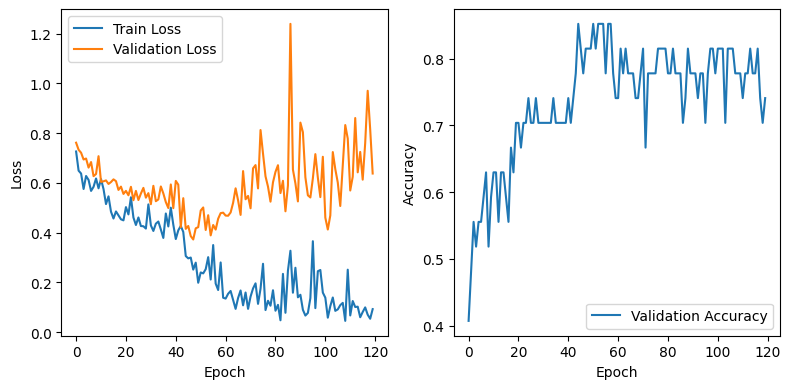

           Validation      Test
Accuracy     0.814815  0.821429
Precision    0.777778  0.823529
Recall       0.933333  0.875000
F1-Score     0.848485  0.848485


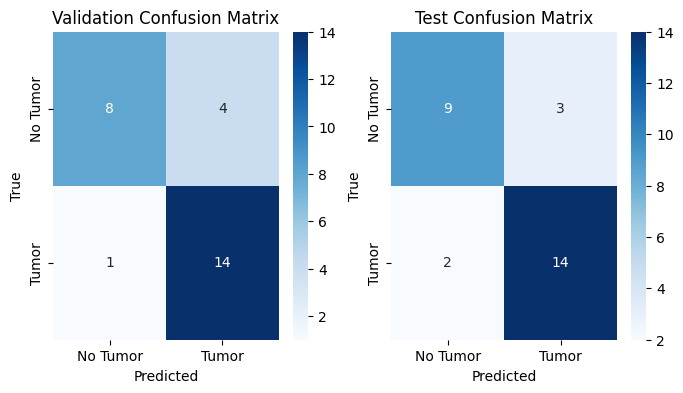

In [9]:
mlflow.set_experiment("Brain Tumor Detection - Model Training and Evaluation")

time_now = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")

mlflow.start_run(run_name=f"densenet121-{time_now}", log_system_metrics=True)

run_id = mlflow.active_run().info.run_id

num_epochs = 120

trainer = train_eval.train.ModelTrainer(
    model=model,
    optimizer=optim,
    criterion=nn.BCELoss(),
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    model_name="densenet121",
    mlflow_logging=True,
    train_transform=processor.train_transform,
    test_transform=processor.test_transform,
    plot=True,
    epoch_finished_callback=epoch_finished_callback,
    extra_mlflow_params=[
        ("Training Type", "Fine-Tuning"),
        (
            "Freezing Layers",
            {
                "Epochs 0-40": "All layers frozen except classifier",
                "Epochs 41-80": "All layers frozen except classifier and denseblock4.denselayer16",
                "Epochs 81-": "All layers frozen except classifier, denseblock4.denselayer15 and denseblock4.denselayer16",
            },
        ),
    ],
)
model = trainer.run()

evaluator = train_eval.eval.ModelEvaluator(
    model=model,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=nn.BCELoss(),
    device=device,
    mlflow_logging=True,
    plot=True,
)
evaluator.run()

mlflow.end_run()